In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import sys
sys.path.append('../../../')
import bemppUQ
import numpy as np
import bempp.api 
from bemppUQ.shapes import kite, perturbate
from bemppUQ.functions import tangential_trace, neumann_trace
from bemppUQ.utils.login import rescale, gmres
from bemppUQ.operators.maxwell import multitrace_identity, multitrace_operator, assemble_operators, evaluate_far_field, evaluate_far_field_sd

from bemppUQ.assembly.operators import DenseTensorLinearOperator

from bempp.api.assembly.blocked_operator import \
        coefficients_of_grid_function_list, \
        projections_of_grid_function_list, \
        grid_function_list_from_coefficients

restart = 100
maxiter = 100
tolerance = 1e-4

number_of_angles = 400
angles = np.pi * np.linspace(0, 2, number_of_angles)
far_field_points = np.array([np.cos(angles), np.sin(angles), np.zeros(number_of_angles)])
case = 'LF'

if case == 'LF':
    polarization = np.array([1.0 + 1j, 2.0, -1.0 - 1.0 / 3.0 * 1j])
    direction = np.array([1.0 / np.sqrt(14), 2.0 / np.sqrt(14), 3.0 / np.sqrt(14)], dtype='float64')

    eps_rel = 1.9
    mu_rel = 1.

    k_ext = 1.047197551196598
    k_int = k_ext * np.sqrt(eps_rel * mu_rel)

    
print("The exterior wavenumber is: {0}".format(k_ext))
print("The interior wavenumber is: {0}".format(k_int))

precision = 10
h = 2.0 * np.pi / (precision * k_int)
h = 1
base_grid = kite(h=h) 

print(base_grid.leaf_view.entity_count(1) * 2, 'Ndof')
# Primal formaulation
transmission_operators = assemble_operators(base_grid, k_int, k_ext, far_field_points, spaces='maxwell_primal', osrc=True)

multitrace_int, multitrace_ext, osrc_int, osrc_ext, identity, electric_far, magnetic_far = transmission_operators

rescaled_osrc_int_op = rescale(osrc_int, np.sqrt(eps_rel), np.sqrt(mu_rel))
rescaled_int_op = rescale(multitrace_int, np.sqrt(eps_rel), np.sqrt(mu_rel))

lhs_osrc = rescaled_osrc_int_op +osrc_ext
lhs_op = rescaled_int_op + multitrace_ext
rhs_op = .5 * identity - rescaled_int_op
electric_incident = bempp.api.GridFunction(lhs_op.domain_spaces[0], fun=tangential_trace(k_ext, polarization, direction))
magnetic_incident = bempp.api.GridFunction(lhs_op.domain_spaces[1], fun=neumann_trace(k_ext, polarization, direction))

rhs = rhs_op * [electric_incident, magnetic_incident]
b = projections_of_grid_function_list(rhs, lhs_op.dual_to_range_spaces)
lhs_op_wf = lhs_op.weak_form()
P = lhs_osrc.weak_form()

print('solver osrc')
A = P * lhs_op_wf
f = P * b
x_osrc, info, res_osrc, times_osrc = gmres(A, f, return_residuals=True, restart=restart, maxiter=maxiter, tol=tolerance)
solution_osrc = grid_function_list_from_coefficients(x_osrc, lhs_op.domain_spaces)
far_field_osrc = 4. * np.pi * ( -electric_far * solution_osrc[1] - magnetic_far * solution_osrc[0])


AA = DenseTensorLinearOperator(A, A)
ff = np.dot(np.array([f]).T, np.array([f])).ravel()
print('solver Osrc')
X_osrc, info, Res_osrc, Times_osrc = gmres( AA ,ff, return_residuals=True,restart=restart, maxiter=maxiter, tol=tolerance)
  

print('solver unpreconditioned')
A = lhs_op_wf
f = b
x_unprec, info, res_unprec, times_unprec = gmres(lhs_op_wf, b, return_residuals=True, restart=restart, maxiter=maxiter, tol=tolerance)
solution_unprec = grid_function_list_from_coefficients(x_unprec, lhs_op.domain_spaces)
far_field_unprec = 4. * np.pi * ( -electric_far * solution_unprec[1] - magnetic_far * solution_unprec[0])

AA = DenseTensorLinearOperator(A, A)
ff = np.dot(np.array([f]).T, np.array([f])).ravel()

print('solver Unpreconditioned')
X_unprec, info, Res_unprec, Times_unprec = gmres( AA ,ff, return_residuals=True,restart=restart, maxiter=maxiter, tol=tolerance)


print('solver dual')
transmission_operators = assemble_operators(base_grid, k_int, k_ext, far_field_points, spaces='maxwell')
multitrace_int, multitrace_ext, identity, electric_far, magnetic_far = transmission_operators
rescaled_int_op = rescale(multitrace_int, np.sqrt(eps_rel), np.sqrt(mu_rel))
lhs_op = rescaled_int_op + multitrace_ext
rhs_op = .5 * identity - rescaled_int_op
electric_incident = bempp.api.GridFunction(lhs_op.domain_spaces[0], fun=tangential_trace(k_ext, polarization, direction),
                                          dual_space=lhs_op.dual_to_range_spaces[0])
magnetic_incident = bempp.api.GridFunction(lhs_op.domain_spaces[1], fun=neumann_trace(k_ext, polarization, direction),
                                          dual_space=lhs_op.dual_to_range_spaces[1])
rhs = rhs_op * [electric_incident, magnetic_incident]
b = coefficients_of_grid_function_list(rhs)
lhs_op_sf = lhs_op.strong_form()

A = lhs_op_sf
f = b

print('solver calderon')
x_cald, info, res_cald, times_cald = gmres(A,f, return_residuals=True, restart=restart, maxiter=maxiter, tol=tolerance)
solution_cald = grid_function_list_from_coefficients(x_cald, lhs_op.domain_spaces)
far_field_cald = 4. * np.pi * ( -electric_far * solution_cald[1] - magnetic_far * solution_cald[0])

AA = DenseTensorLinearOperator(A, A)
ff = np.dot(np.array([f]).T, np.array([f])).ravel()

print('solver Calderon')
X_cald, info, Res_cald, Times_cald = gmres( AA ,ff, return_residuals=True,restart=restart, maxiter=maxiter, tol=tolerance)


A = (lhs_op * lhs_op).strong_form()
f = coefficients_of_grid_function_list(lhs_op * rhs)

print('solver calderon 2')
x_cald2, info, res_cald2, times_cald2 = gmres(A,f, return_residuals=True, restart=restart, maxiter=maxiter, tol=tolerance)
solution_cald = grid_function_list_from_coefficients(x_cald, lhs_op.domain_spaces)
far_field_cald = 4. * np.pi * ( -electric_far * solution_cald[1] - magnetic_far * solution_cald[0])

AA = DenseTensorLinearOperator(A, A)
ff = np.dot(np.array([f]).T, np.array([f])).ravel()

print('solver Calderon 2')
X_cald, info, Res_cald2, Times_cald2 = gmres( AA ,ff, return_residuals=True,restart=restart, maxiter=maxiter, tol=tolerance)


The exterior wavenumber is: 1.047197551196598
The interior wavenumber is: 1.4434622098763403
144 Ndof
solver osrc
iteration - 1 || residual - 0.36160810710843916 0.006905794143676758
iteration - 2 || residual - 0.2240798337590747 0.003137826919555664
iteration - 3 || residual - 0.13145081318899554 0.0026693344116210938
iteration - 4 || residual - 0.07400585590278876 0.0029113292694091797
iteration - 5 || residual - 0.036951877672593496 0.003067493438720703
iteration - 6 || residual - 0.020309685836651714 0.003186464309692383
iteration - 7 || residual - 0.012204354243556556 0.002831697463989258
iteration - 8 || residual - 0.005589008536386545 0.0029497146606445312
iteration - 9 || residual - 0.0035743002576041284 0.0027365684509277344
iteration - 10 || residual - 0.002035282049344677 0.0026819705963134766
iteration - 11 || residual - 0.0010956875827359965 0.0027539730072021484
iteration - 12 || residual - 0.0006893534125033164 0.002730846405029297
iteration - 13 || residual - 0.00041222

iteration - 1 || residual - 0.9999996267325266 0.48490118980407715
iteration - 2 || residual - 0.9889819094798941 0.14454984664916992
iteration - 3 || residual - 0.9888967946773313 0.13920092582702637
iteration - 4 || residual - 0.9823639337990722 0.13541793823242188
iteration - 5 || residual - 0.982273111729239 0.16770505905151367
iteration - 6 || residual - 0.9786356129979612 0.12368369102478027
iteration - 7 || residual - 0.9781753717768551 0.12632393836975098
iteration - 8 || residual - 0.9673416890102933 0.16783738136291504
iteration - 9 || residual - 0.9671527998604551 0.12983345985412598
iteration - 10 || residual - 0.9596966385233712 0.13422322273254395
iteration - 11 || residual - 0.9587653686106788 0.135711669921875
iteration - 12 || residual - 0.9355722510355908 0.1494157314300537
iteration - 13 || residual - 0.934730431038822 0.13208603858947754
iteration - 14 || residual - 0.9254211124711846 0.12387609481811523
iteration - 15 || residual - 0.925273084497933 0.1287739276885

iteration - 12 || residual - 0.0003064159424507726 1.7745404243469238
iteration - 13 || residual - 0.00011737620263198039 1.7665836811065674
iteration - 14 || residual - 8.752357559551614e-05 1.788863182067871
solver calderon 2
iteration - 1 || residual - 0.18651479076120278 0.08523321151733398
iteration - 2 || residual - 0.024020057150989642 0.01741504669189453
iteration - 3 || residual - 0.0034886220353163087 0.01705646514892578
iteration - 4 || residual - 0.0005019054539645185 0.0173187255859375
iteration - 5 || residual - 8.232072890546203e-05 0.017360210418701172
solver Calderon 2
iteration - 1 || residual - 0.26146767601470156 10.610480546951294
iteration - 2 || residual - 0.07973637186388825 3.466931104660034
iteration - 3 || residual - 0.01988253080929104 3.477271795272827
iteration - 4 || residual - 0.0050223355368349655 3.5135555267333984
iteration - 5 || residual - 0.0013135921879739827 3.5132904052734375
iteration - 6 || residual - 0.0003679613041642827 3.526205539703369
it

In [17]:

name = (
"results/"
    + "precision"
+ str(precision)
+ "_case"
+ str(case))

my_dict = {
        "res_unprec": res_unprec,
        "res_osrc": res_osrc,
        "res_cald": res_cald,
        "res_cald2": res_cald2,        
    }

np.save(name + ".npy", my_dict)        

FileNotFoundError: [Errno 2] No such file or directory: 'results/precision10_caseLF.npy'

In [2]:
from matplotlib import pyplot as plt

plt.figure(figsize= (15,7))

#cs = 10 * np.log10(4 * np.pi * np.sum(np.abs(far_field_dual)**2, axis=0))
cs_osrc = 10 * np.log10(4 * np.pi * np.sum(np.abs(far_field_osrc)**2, axis=0))
cs_unprec = 10 * np.log10(4 * np.pi * np.sum(np.abs(far_field_unprec)**2, axis=0))
cs_cald = 10 * np.log10(4 * np.pi * np.sum(np.abs(far_field_cald)**2, axis=0))
#cs_cald2 = 10 * np.log10(4 * np.pi * np.sum(np.abs(far_field_cald2)**2, axis=0))

plt.plot(cs_osrc, '-o', label='ref')
plt.plot(cs_unprec, color = 'k', label='mo')
plt.plot(cs_cald, color = 'k', label='mo')


plt.legend()

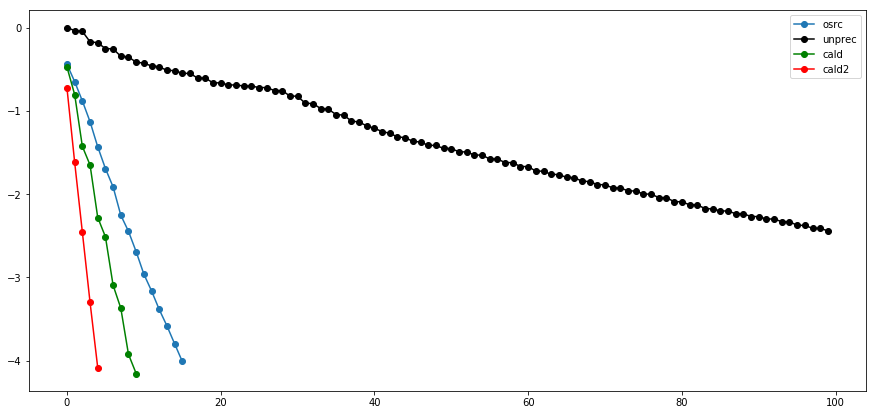

In [3]:
from matplotlib import pyplot as plt

plt.figure(figsize= (15,7))

plt.plot(np.log10(res_osrc), '-o', label='osrc')
plt.plot(np.log10(res_unprec), '-ko', label='unprec')
plt.plot(np.log10(res_cald), '-go', label='cald')
plt.plot(np.log10(res_cald2), '-ro', label='cald2')
plt.legend()

In [11]:
res_osrc = np.array(res_osrc)
res_unprec = np.array(res_unprec)
res_cald = np.array(res_cald)
res_cald2 = np.array(res_cald2)


cum_osrc = np.cumsum(times_osrc)
cum_unprec = np.cumsum(times_unprec)
cum_cald = np.cumsum(times_cald)
cum_cald2 = np.cumsum(times_cald2)

print(cum_cald2.shape, res_cald2.shape)

(5,) (5,)


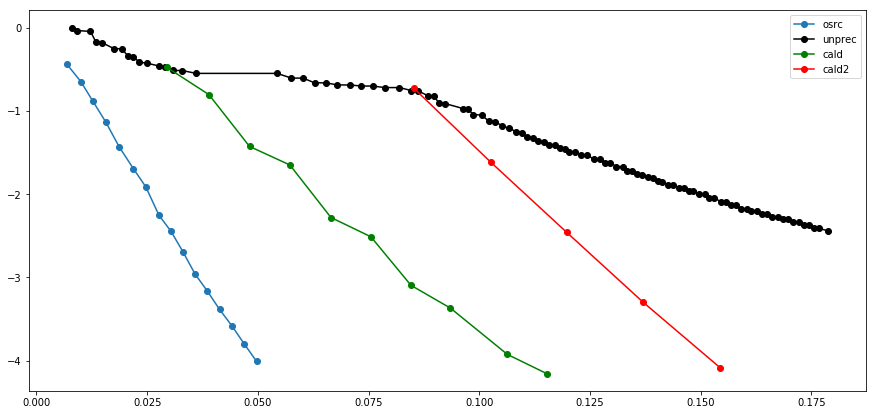

In [12]:
from matplotlib import pyplot as plt

plt.figure(figsize= (15,7))

plt.plot(cum_osrc, np.log10(res_osrc), '-o', label='osrc')
plt.plot(cum_unprec, np.log10(res_unprec), '-ko', label='unprec')
plt.plot(cum_cald, np.log10(res_cald), '-go', label='cald')
plt.plot(cum_cald2, np.log10(res_cald2), '-ro', label='cald2')
plt.legend()

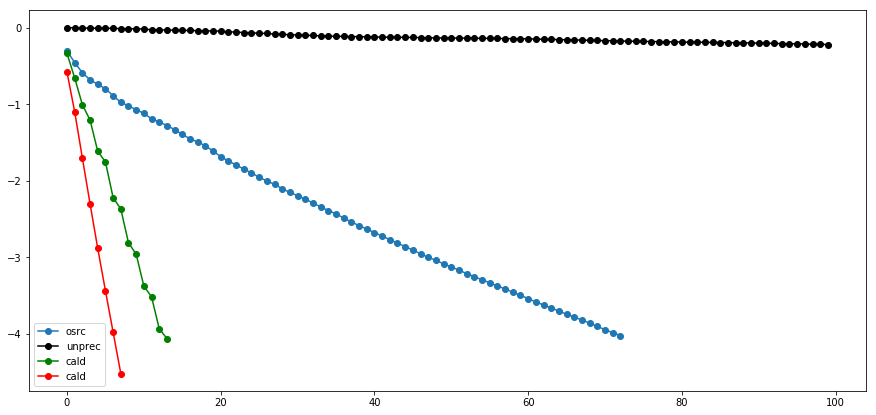

In [13]:
from matplotlib import pyplot as plt

plt.figure(figsize= (15,7))

plt.plot(np.log10(Res_osrc), '-o', label='osrc')
plt.plot(np.log10(Res_unprec), '-ko', label='unprec')
plt.plot(np.log10(Res_cald), '-go', label='cald')
plt.plot(np.log10(Res_cald2), '-ro', label='cald')
plt.legend()

In [14]:
Cum_osrc = np.cumsum(Times_osrc)
Cum_unprec = np.cumsum(Times_unprec)
Cum_cald = np.cumsum(Times_cald)
Cum_cald2 = np.cumsum(Times_cald2)

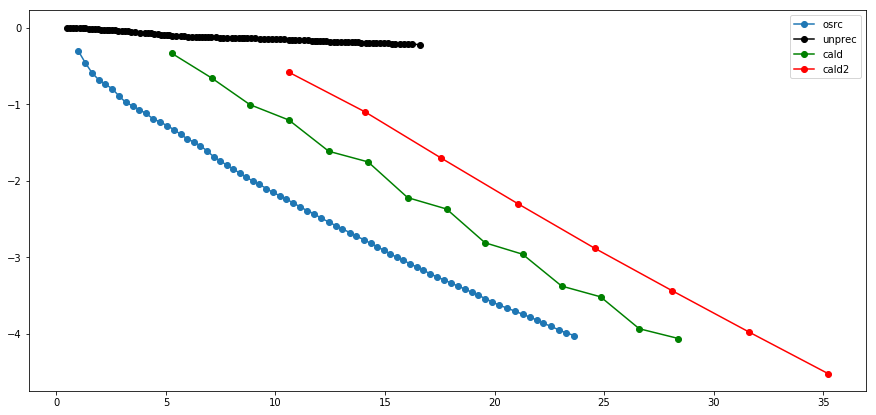

In [15]:
from matplotlib import pyplot as plt

plt.figure(figsize= (15,7))

plt.plot(Cum_osrc, np.log10(Res_osrc), '-o', label='osrc')
plt.plot(Cum_unprec, np.log10(Res_unprec), '-ko', label='unprec')
plt.plot(Cum_cald, np.log10(Res_cald), '-go', label='cald')
plt.plot(Cum_cald2, np.log10(Res_cald2), '-ro', label='cald2')
plt.legend()
